<a href="https://colab.research.google.com/github/mlengineer007/covid-19/blob/master/covid-19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import  pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from shapely.geometry  import point,polygon
import plotly.express as px
import seaborn as sns
import geopandas as gpd
import warnings
import plotly as p
from fbprophet import Prophet
import folium

In [0]:
!pip install geopandas

     |████████████████████████████████| 931kB 3.4MB/s 
     |████████████████████████████████| 10.4MB 9.5MB/s 
     |████████████████████████████████| 14.7MB 335kB/s 


In [0]:
confirmed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/time_series_covid19_confirmed_global copy.csv")
death = pd.read_csv("/content/drive/My Drive/Colab Notebooks/time_series_covid19_deaths_global copy.csv")
recovered = pd.read_csv("/content/drive/My Drive/Colab Notebooks/time_series_covid19_recovered_global.csv")
print(confirmed.shape)
print(death.shape)
print(recovered.shape)

confirmed['Province/State'].fillna(confirmed['Country/Region'], inplace=True)
death['Province/State'].fillna(death['Country/Region'], inplace=True)
recovered['Province/State'].fillna(recovered['Country/Region'], inplace=True)

confirmed = pd.melt(confirmed,id_vars=['Province/State','Country/Region','Lat','Long'],var_name=['date'])
death = pd.melt(death,id_vars=['Province/State','Country/Region','Lat','Long'],var_name=['date'])
recovered = pd.melt(recovered,id_vars=['Province/State','Country/Region','Lat','Long'],var_name=['date'])

confirmed['date'] = pd.to_datetime(confirmed['date'])
death['date'] = pd.to_datetime(death['date'])
recovered['date'] = pd.to_datetime(recovered['date'])

print(confirmed.head())
print(death.tail())
print(confirmed.tail())
print(death.shape)
print(recovered.shape)
confirmed.columns = confirmed.columns.str.replace('value','confirmed')
death.columns = death.columns.str.replace('value','deaths')
recovered.columns = recovered.columns.str.replace('value','recovered')
print(confirmed.tail())
print(death.tail())
print(recovered.tail())
rrecovered = recovered.fillna(0)

covid19 = confirmed.merge(death[['Province/State','Country/Region','date','deaths']], how="left", left_on = ['Province/State','Country/Region','date'],    right_on = ['Province/State', 'Country/Region','date'])
covid19 = covid19.merge(recovered[['Province/State','Country/Region','date','recovered']], how = 'left',left_on = ['Province/State','Country/Region','date'],  right_on = ['Province/State', 'Country/Region','date'])

print(covid19.isnull().sum())
covid19["recovered"]=covid19["recovered"].fillna(0)
print(covid19.isnull().sum())
print(covid19.head())
print(covid19.tail())
covid19.shape


(264, 97)
(264, 97)
(250, 97)
  Province/State Country/Region      Lat     Long       date  value
0    Afghanistan    Afghanistan  33.0000  65.0000 2020-01-22      0
1        Albania        Albania  41.1533  20.1683 2020-01-22      0
2        Algeria        Algeria  28.0339   1.6596 2020-01-22      0
3        Andorra        Andorra  42.5063   1.5218 2020-01-22      0
4         Angola         Angola -11.2027  17.8739 2020-01-22      0
                  Province/State         Country/Region  ...       date  value
24547  Saint Pierre and Miquelon                 France  ... 2020-04-23      0
24548                South Sudan            South Sudan  ... 2020-04-23      0
24549             Western Sahara         Western Sahara  ... 2020-04-23      0
24550      Sao Tome and Principe  Sao Tome and Principe  ... 2020-04-23      0
24551                      Yemen                  Yemen  ... 2020-04-23      0

[5 rows x 6 columns]
                  Province/State         Country/Region  ...      

(24552, 8)

In [0]:
confirmed = covid19.groupby('date').sum()['confirmed'].reset_index()
confirmed.shape
deaths = covid19.groupby('date').sum()['deaths'].reset_index()
recovered = covid19.groupby('date').sum()['recovered'].reset_index()
confirmed.columns=['ds','y']
print(confirmed.tail(5))
confirmed['ds'] = pd.to_datetime(confirmed['ds'])
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=15)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds        y
88 2020-04-19  2401101
89 2020-04-20  2472258
90 2020-04-21  2549122
91 2020-04-22  2624089
92 2020-04-23  2708884


,ds
103,2020-05-04
104,2020-05-05
105,2020-05-06
106,2020-05-07
107,2020-05-08


In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
103,2020-05-04,3.616761e+06,3.515048e+06,3.731647e+06
104,2020-05-05,3.695878e+06,3.585260e+06,3.827744e+06
105,2020-05-06,3.776761e+06,3.650753e+06,3.927316e+06
106,2020-05-07,3.862082e+06,3.717866e+06,4.031513e+06
107,2020-05-08,3.947674e+06,3.787347e+06,4.124489e+06


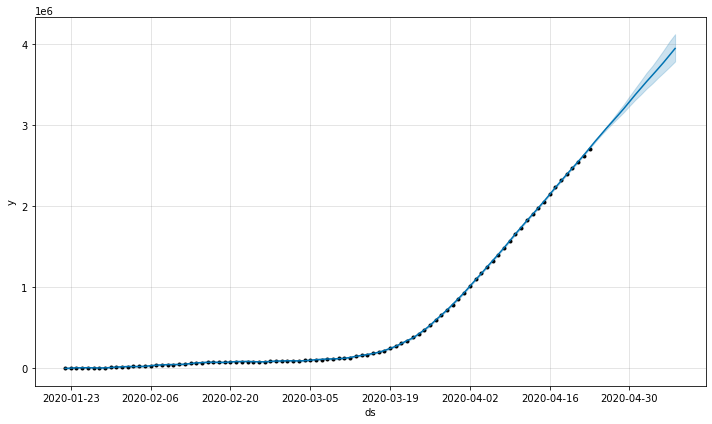

In [0]:
from google.colab import files
confirmed_forecast_plot = m.plot(forecast)
plt.savefig("confirmed_forcast.png")
files.download("confirmed_forcast.png")

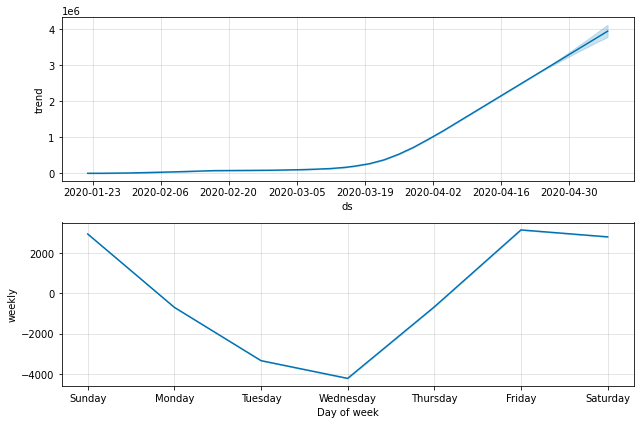

In [0]:
confirmed_forecast_plot =m.plot_components(forecast)
plt.savefig("Conf_weekly.png")
files.download("Conf_weekly.png")

In [0]:
recovered.columns = ['ds','y']
recovered['ds'] = pd.to_datetime(recovered['ds'])

In [0]:
m = Prophet(interval_width=0.95)
m.fit(recovered)
future = m.make_future_dataframe(periods=15)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
103,2020-05-04
104,2020-05-05
105,2020-05-06
106,2020-05-07
107,2020-05-08


In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
103,2020-05-04,9.901159e+05,9.541272e+05,1.024049e+06
104,2020-05-05,1.016401e+06,9.744553e+05,1.053433e+06
105,2020-05-06,1.043598e+06,9.988053e+05,1.085456e+06
106,2020-05-07,1.070101e+06,1.021109e+06,1.113972e+06
107,2020-05-08,1.094391e+06,1.040161e+06,1.148737e+06


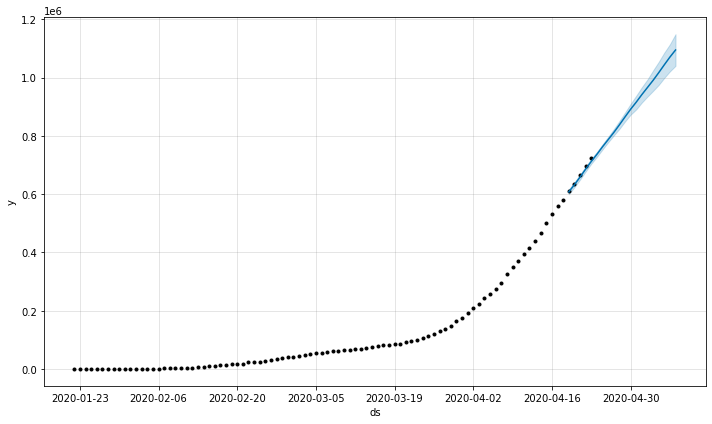

In [0]:
recovered_forecast_plot = m.plot(forecast.tail(20))
plt.savefig("recovered_forcast.png")
files.download("recovered_forcast.png")

In [0]:
deaths.columns = ['ds','y']
deaths['ds'] = pd.to_datetime(deaths['ds'])

In [0]:
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods=15)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
103,2020-05-04
104,2020-05-05
105,2020-05-06
106,2020-05-07
107,2020-05-08


In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
103,2020-05-04,264535.142866,255332.588694,272822.704753
104,2020-05-05,271286.285934,260877.849918,281084.921104
105,2020-05-06,278204.196009,266966.779182,289482.380922
106,2020-05-07,285406.561016,273084.807574,298243.128563
107,2020-05-08,292548.573599,279145.001419,306447.557655


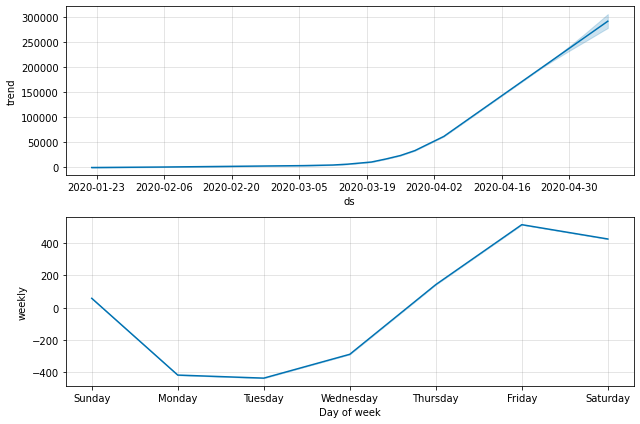

In [0]:
confirmed_forecast_plot =m.plot_components(forecast)
plt.savefig("death_weekly.png")
files.download("death_weekly.png")

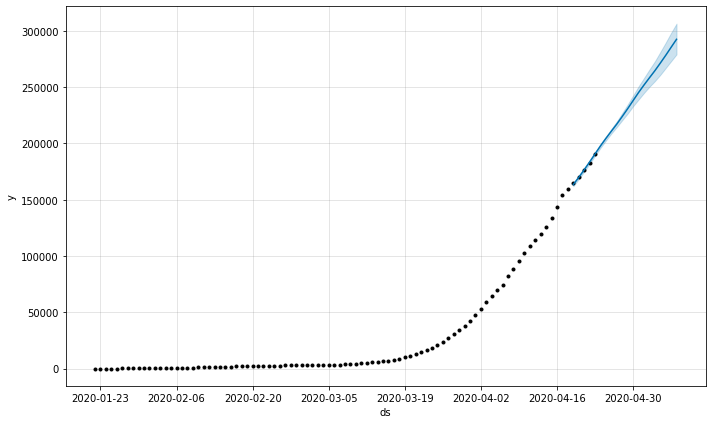

In [0]:
recovered_forecast_plot = m.plot(forecast.tail(20))
plt.savefig("death_forcast.png")
files.download("death_forcast.png")

In [0]:
covid19.groupby('Province/State')['confirmed'].max()

Province/State
Afghanistan    1279
Albania         663
Alberta        3720
Algeria        3007
Andorra         723
               ... 
Yukon            11
Yunnan          184
Zambia           76
Zhejiang       1268
Zimbabwe         28
Name: confirmed, Length: 263, dtype: int64

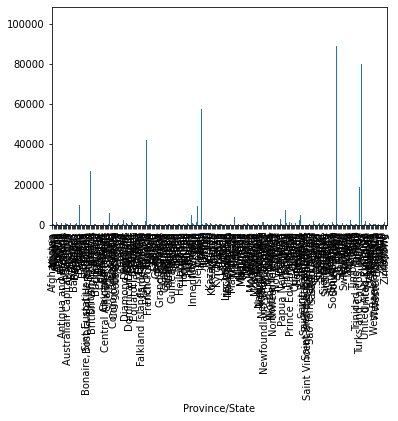

In [0]:
l = covid19.groupby('country')['recovered'].max()


In [0]:
k = covid19.groupby('Province/State')['deaths'].max()
print(k.idxmax())
k.max()

US


49954

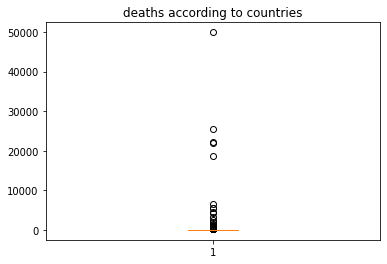

In [0]:
plt.boxplot(k)
plt.title('deaths according to countries')
plt.savefig("deaths_bp.png")
files.download("deaths_bp.png")

In [0]:
map = folium.Map(location=[20, 70], zoom_start=4,tiles='Stamenterrain')

for lat, lon, value, name in zip(covid19['Lat'], covid19['Long'], covid19['confirmed'], covid19['Province/State']):
    folium.CircleMarker([lat, lon], radius=value*0.8, popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>''<strong>Total Cases</strong>: ' + str(value) + '<br>'),color='red',fill_color='red',fill_opacity=0.3 ).add_to(map)
map


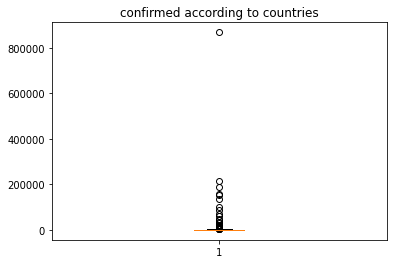

In [0]:
plt.boxplot(k)
plt.title('confirmed according to countries')
plt.savefig("confirmed_bp.png")
files.download("confirmed_bp.png")

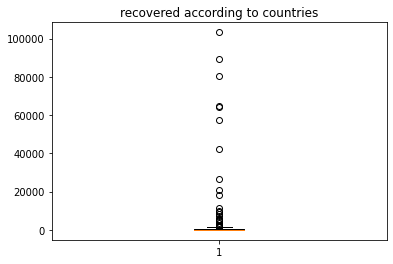

In [0]:
plt.boxplot(k)
plt.title('recovered according to countries')
plt.savefig("recovered_bp.png")
files.download("recovered_bp.png")

In [0]:
last_date =covid19['date'].max()
df_countries = covid19[covid19['date']==last_date]
df_countries =covid19.groupby('Province/State',as_index=False)['confirmed','deaths','recovered'].sum()
df_countries = df_countries.nlargest(10,'confirmed')
df_trend = covid19.groupby(['date','Province/State'],as_index=False)['confirmed','deaths','recovered'].sum()
df_trend = df_trend.merge(df_countries, on='Province/State')
df_trend.rename(columns={'Province/State':'Country', 'confirmed_x':'Cases', 'deaths_x':'Deaths','recovered_x':'recovered'}, inplace=True)
df_trend['log(Cases)'] = np.log(df_trend['Cases']+1)# Added 1 to remove error due to log(0).
df_trend['log(Deaths)'] = np.log(df_trend['Deaths']+1)
df_trend['log(recovered)'] = np.log(df_trend['recovered']+1)
df_trend.head()


        date Province/State  confirmed_x  ...  confirmed_y  deaths_y  recovered_y
0 2020-01-22        Belgium            0  ...       756497     85486     150010.0
1 2020-01-23        Belgium            0  ...       756497     85486     150010.0
2 2020-01-24        Belgium            0  ...       756497     85486     150010.0
3 2020-01-25        Belgium            0  ...       756497     85486     150010.0
4 2020-01-26        Belgium            0  ...       756497     85486     150010.0

[5 rows x 8 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,date,Country,Cases,Deaths,recovered,confirmed_y,deaths_y,recovered_y,log(Cases),log(Deaths),log(recovered)
0,2020-01-22,Belgium,0,0,0.0,756497,85486,150010.0,0.0,0.0,0.0
1,2020-01-23,Belgium,0,0,0.0,756497,85486,150010.0,0.0,0.0,0.0
2,2020-01-24,Belgium,0,0,0.0,756497,85486,150010.0,0.0,0.0,0.0
3,2020-01-25,Belgium,0,0,0.0,756497,85486,150010.0,0.0,0.0,0.0
4,2020-01-26,Belgium,0,0,0.0,756497,85486,150010.0,0.0,0.0,0.0


In [0]:
px.line(df_trend, x='date', y='Cases', color='Country', title='COVID19 Total Cases growth for top 10 worst affected countries')


In [0]:
px.line(df_trend, x='date', y='Deaths', color='Country', title='COVID19 Total deaths growth for top 10 worst affected countries')


In [0]:
px.line(df_trend, x='date', y='recovered', color='Country', title='COVID19 Total recovered growth for top 10 worst affected countries')


In [0]:
covid19.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
date              datetime64[ns]
confirmed                  int64
deaths                     int64
recovered                float64
dtype: object